In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm, tqdm_pandas

% matplotlib inline

In [2]:
%cd C:\\Users\\sebsa\\Documents\\Centrale Paris\\3A\\OEN\\Projet Synthese\\data

C:\Users\sebsa\Documents\Centrale Paris\3A\OEN\Projet Synthese\data


## Read and format data

### ASU

In [23]:
df_ASU = pd.read_excel('GPS and NRJ - Europe.xlsx', skiprows=[0,1,2], encoding='utf-8')
df_ASU = df_ASU[np.isfinite(df_ASU['Site Latitude'])]
df_ASU = df_ASU[np.isfinite(df_ASU['Site Longitude'])]
df_ASU.Country.fillna(method='ffill', inplace=True)
df_ASU.head()

,Country,Plant,Site Latitude,Site Longitude,2016-01-01 00:00:00,2016-02-01 00:00:00,2016-03-01 00:00:00,2016-04-01 00:00:00,2016-05-01 00:00:00,2016-06-01 00:00:00,...,2017-03-01 00:00:00.1,2017-04-01 00:00:00.1,2017-05-01 00:00:00.1,2017-06-01 00:00:00.1,2017-07-01 00:00:00.1,2017-08-01 00:00:00.1,2017-09-01 00:00:00.1,2017-10-01 00:00:00.1,2017-11-01 00:00:00.1,2017-12-01 00:00:00.1
0,Austria,P_Donawitz_Combo,4.738002e+06,1.506349e+07,9041.0,8713.0,9662.0,9367.0,10027.0,9724.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Austria,P_Donawitz_Sigma,4.738002e+06,1.506349e+07,3315.0,3385.0,3442.0,3582.0,3396.0,3144.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Austria,P_Schwechat,4.814602e+07,1.648054e+07,6001.0,6650.0,6596.0,7088.0,6567.0,7137.0,...,0.9405,0.9743,0.9057,1.0089,0.9758,0.9520,0.9888,1.0331,1.0243,0.5369
3,Belgium,P_Antwerpen ASU,5.132264e+08,4.284417e+14,52483.0,49165.0,51781.0,53978.0,49456.0,45351.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Belgium,P_Charleroi,5.041000e+01,4.400000e+00,26343.0,26481.0,26523.0,21445.0,23478.0,22228.0,...,0.9120,0.9202,0.8658,0.8530,0.8855,0.9386,0.7946,0.9033,0.9132,0.7636


In [24]:
def conv2lat(float_number):
    zou = float_number
    i = 0
    while abs(zou) != 0.:
        zou = zou//10
        i += 1
    return float_number / (10**(i-2))

def conv2lon(float_number):
    zou = float_number
    i = 0
    while ((abs(zou) != 0.) & (abs(zou) != 1.)):
        zou = zou//10
        i += 1
    return float_number / (10**(i-1))

In [25]:
tqdm.pandas()
df_ASU['lat'] = df_ASU['Site Latitude'].progress_apply(conv2lat)
df_ASU['lon'] = df_ASU['Site Longitude'].progress_apply(conv2lon)

100%|███████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 45335.75it/s]


In [26]:
df_ASU.head(15)

,Country,Plant,Site Latitude,Site Longitude,2016-01-01 00:00:00,2016-02-01 00:00:00,2016-03-01 00:00:00,2016-04-01 00:00:00,2016-05-01 00:00:00,2016-06-01 00:00:00,...,2017-05-01 00:00:00.1,2017-06-01 00:00:00.1,2017-07-01 00:00:00.1,2017-08-01 00:00:00.1,2017-09-01 00:00:00.1,2017-10-01 00:00:00.1,2017-11-01 00:00:00.1,2017-12-01 00:00:00.1,lat,lon
0,Austria,P_Donawitz_Combo,4.738002e+06,1.506349e+07,9041.0,8713.0,9662.0,9367.0,10027.0,9724.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,47.380020,15.063486
1,Austria,P_Donawitz_Sigma,4.738002e+06,1.506349e+07,3315.0,3385.0,3442.0,3582.0,3396.0,3144.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,47.380020,15.063486
2,Austria,P_Schwechat,4.814602e+07,1.648054e+07,6001.0,6650.0,6596.0,7088.0,6567.0,7137.0,...,0.9057,1.0089,0.9758,0.9520,0.9888,1.0331,1.0243,0.5369,48.146024,16.480538
3,Belgium,P_Antwerpen ASU,5.132264e+08,4.284417e+14,52483.0,49165.0,51781.0,53978.0,49456.0,45351.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,51.322639,4.284417
4,Belgium,P_Charleroi,5.041000e+01,4.400000e+00,26343.0,26481.0,26523.0,21445.0,23478.0,22228.0,...,0.8658,0.8530,0.8855,0.9386,0.7946,0.9033,0.9132,0.7636,50.410000,4.400000
5,Belgium,P_Mons,5.047670e+07,3.854781e+06,1070.0,1095.0,4157.0,10416.0,4828.0,1021.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50.476698,3.854781
6,Belgium,P_Seraing,5.060209e+07,5.501615e+06,25403.0,26876.0,27256.0,25679.0,26373.0,25692.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50.602086,5.501615
7,Bulgaria,P_Pernik,4.260016e+07,2.311241e+07,4700.0,4109.0,4489.0,4463.0,4554.0,4700.0,...,0.6091,0.5508,0.5612,0.3187,0.5393,0.6032,0.5196,0.5012,42.600162,2.311241
8,Bulgaria,P_Pirdop,4.272103e+07,2.416752e+07,10483.0,9925.0,10472.0,5512.0,303.0,10369.0,...,0.9594,0.9834,0.9607,1.0223,1.0680,1.0460,1.0855,1.0999,42.721028,2.416752
9,Bulgaria,P_Targovishte,4.326611e+07,2.652252e+07,2258.0,2156.0,2296.0,2240.0,2324.0,2261.0,...,0.7257,0.7617,0.7831,0.7989,0.7827,0.7808,0.7858,0.7940,43.266108,2.652252


### Buses

In [27]:
path = 'reseau/buses_formatted.csv'
buses = pd.read_csv(path, index_col=0)
buses.head()

,bus_id,station_id,voltage,dc,symbol,lon,lat
26,6723,7564,380.0,f,joint,-0.977047,37.961746
27,6724,7565,380.0,f,joint,-0.769043,39.436193
28,6725,7566,380.0,f,joint,-0.296631,40.195659
56,6726,7567,380.0,f,joint,21.718037,42.033235
57,6727,7568,380.0,f,joint,22.061897,42.033604


## Associate

In [28]:
from math import cos, asin, sqrt
from tqdm import tqdm

def distance(lat1, lon1, lat2, lon2):
    p = 0.017453292519943295
    a = 0.5 - cos((lat2-lat1)*p)/2 + cos(lat1*p)*cos(lat2*p) * (1-cos((lon2-lon1)*p)) / 2
    return 12742 * asin(sqrt(a))

def closest(data, v):
    list_dist = []
    for p in data:
        list_dist.append(distance(v['lat'],v['lon'],p['lat'],p['lon']))
    return (list_dist.index(min(list_dist)), min(list_dist))
#     return min(data, key=lambda p: distance(v['lat'],v['lon'],p['lat'],p['lon']))

tempDataList = [{'lat': 39.7612992, 'lon': -86.1519681}, 
                {'lat': 39.762241,  'lon': -86.158436 }, 
                {'lat': 39.7622292, 'lon': -86.1578917}]

v = {'lat': 39.7622290, 'lon': -86.1519750}
index_bus, dist = closest(tempDataList, v)
print(index_bus)
print(dist)

0
0.10339070310220466


In [29]:
datalist = buses.to_dict(orient='records')

for index, row in tqdm(df_ASU.iterrows()):
    mypoint = {'lat': row['lat'], 'lon': row['lon']}
    index_bus, dist = closest(datalist, mypoint)
    df_ASU.set_value(index, 'bus_id', buses.iloc[index_bus]['bus_id'])
    df_ASU.set_value(index, 'dist_bus_km', dist)

91it [00:02, 40.06it/s]


In [30]:
df_ASU.bus_id = df_ASU.bus_id.astype('int64')

In [31]:
df_ASU.head(15)

,Country,Plant,Site Latitude,Site Longitude,2016-01-01 00:00:00,2016-02-01 00:00:00,2016-03-01 00:00:00,2016-04-01 00:00:00,2016-05-01 00:00:00,2016-06-01 00:00:00,...,2017-07-01 00:00:00.1,2017-08-01 00:00:00.1,2017-09-01 00:00:00.1,2017-10-01 00:00:00.1,2017-11-01 00:00:00.1,2017-12-01 00:00:00.1,lat,lon,bus_id,dist_bus_km
0,Austria,P_Donawitz_Combo,4.738002e+06,1.506349e+07,9041.0,8713.0,9662.0,9367.0,10027.0,9724.0,...,NaN,NaN,NaN,NaN,NaN,NaN,47.380020,15.063486,4331,20.907934
1,Austria,P_Donawitz_Sigma,4.738002e+06,1.506349e+07,3315.0,3385.0,3442.0,3582.0,3396.0,3144.0,...,NaN,NaN,NaN,NaN,NaN,NaN,47.380020,15.063486,4331,20.907934
2,Austria,P_Schwechat,4.814602e+07,1.648054e+07,6001.0,6650.0,6596.0,7088.0,6567.0,7137.0,...,0.9758,0.9520,0.9888,1.0331,1.0243,0.5369,48.146024,16.480538,4329,9.231421
3,Belgium,P_Antwerpen ASU,5.132264e+08,4.284417e+14,52483.0,49165.0,51781.0,53978.0,49456.0,45351.0,...,NaN,NaN,NaN,NaN,NaN,NaN,51.322639,4.284417,5363,2.235958
4,Belgium,P_Charleroi,5.041000e+01,4.400000e+00,26343.0,26481.0,26523.0,21445.0,23478.0,22228.0,...,0.8855,0.9386,0.7946,0.9033,0.9132,0.7636,50.410000,4.400000,4347,7.314492
5,Belgium,P_Mons,5.047670e+07,3.854781e+06,1070.0,1095.0,4157.0,10416.0,4828.0,1021.0,...,NaN,NaN,NaN,NaN,NaN,NaN,50.476698,3.854781,5050,19.292588
6,Belgium,P_Seraing,5.060209e+07,5.501615e+06,25403.0,26876.0,27256.0,25679.0,26373.0,25692.0,...,NaN,NaN,NaN,NaN,NaN,NaN,50.602086,5.501615,4387,4.749962
7,Bulgaria,P_Pernik,4.260016e+07,2.311241e+07,4700.0,4109.0,4489.0,4463.0,4554.0,4700.0,...,0.5612,0.3187,0.5393,0.6032,0.5196,0.5012,42.600162,2.311241,6068,30.296463
8,Bulgaria,P_Pirdop,4.272103e+07,2.416752e+07,10483.0,9925.0,10472.0,5512.0,303.0,10369.0,...,0.9607,1.0223,1.0680,1.0460,1.0855,1.0999,42.721028,2.416752,6068,24.440754
9,Bulgaria,P_Targovishte,4.326611e+07,2.652252e+07,2258.0,2156.0,2296.0,2240.0,2324.0,2261.0,...,0.7831,0.7989,0.7827,0.7808,0.7858,0.7940,43.266108,2.652252,4573,1.339529


In [32]:
df_ASU.to_csv('all_ASU_with_bus.csv', encoding='utf-8')

## Explore

In [33]:
df_ASU = pd.read_csv('all_ASU_with_bus.csv', index_col=0)
df_ASU.head()

,Country,Plant,Site Latitude,Site Longitude,2016-01-01 00:00:00,2016-02-01 00:00:00,2016-03-01 00:00:00,2016-04-01 00:00:00,2016-05-01 00:00:00,2016-06-01 00:00:00,...,2017-07-01 00:00:00.1,2017-08-01 00:00:00.1,2017-09-01 00:00:00.1,2017-10-01 00:00:00.1,2017-11-01 00:00:00.1,2017-12-01 00:00:00.1,lat,lon,bus_id,dist_bus_km
0,Austria,P_Donawitz_Combo,4.738002e+06,1.506349e+07,9041.0,8713.0,9662.0,9367.0,10027.0,9724.0,...,NaN,NaN,NaN,NaN,NaN,NaN,47.380020,15.063486,4331,20.907934
1,Austria,P_Donawitz_Sigma,4.738002e+06,1.506349e+07,3315.0,3385.0,3442.0,3582.0,3396.0,3144.0,...,NaN,NaN,NaN,NaN,NaN,NaN,47.380020,15.063486,4331,20.907934
2,Austria,P_Schwechat,4.814602e+07,1.648054e+07,6001.0,6650.0,6596.0,7088.0,6567.0,7137.0,...,0.9758,0.9520,0.9888,1.0331,1.0243,0.5369,48.146024,16.480538,4329,9.231421
3,Belgium,P_Antwerpen ASU,5.132264e+08,4.284417e+14,52483.0,49165.0,51781.0,53978.0,49456.0,45351.0,...,NaN,NaN,NaN,NaN,NaN,NaN,51.322639,4.284417,5363,2.235958
4,Belgium,P_Charleroi,5.041000e+01,4.400000e+00,26343.0,26481.0,26523.0,21445.0,23478.0,22228.0,...,0.8855,0.9386,0.7946,0.9033,0.9132,0.7636,50.410000,4.400000,4347,7.314492


In [34]:
df_ASU.dist_bus_km.describe()

count     91.000000
mean      43.181192
std       90.193429
min        0.775336
25%        5.034344
50%        7.739852
75%       20.907934
max      500.639698
Name: dist_bus_km, dtype: float64

Number of points under 200 km : 84
Number of points above 200 km : 7


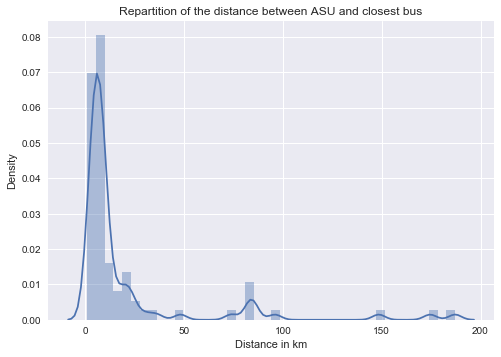

In [36]:
sns.set(color_codes=True)

limit = 200
print('Number of points under {0} km : {1}'
      .format(limit,df_ASU.dist_bus_km[df_ASU.dist_bus_km <= limit].count()))
print('Number of points above {0} km : {1}'
      .format(limit,df_ASU.dist_bus_km[df_ASU.dist_bus_km > limit].count()))

sns.distplot(df_ASU.dist_bus_km[df_ASU.dist_bus_km <= limit])
sns.plt.title('Repartition of the distance between ASU and closest bus')
sns.plt.xlabel('Distance in km')
sns.plt.ylabel('Density')